# ChordNet
A simple Convolutional Neural Network (CNN) to identify if a chord is minor or major

In [ ]:
# import necessary libraries

from IPython.display import Audio
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
import librosa
import cv2
import os

In [ ]:
def readAudio(directory):
    ''' Function to read wav files using librosa '''
    audio, sr = librosa.load(directory, sr=16000)

    # normalize
    audio = audio / max(audio)
    return (audio, sr)

In [ ]:
drive_path = "/content/drive/MyDrive/chords"

major = []
minor = []


for chord_type in ["major", "minor"]:
  chord_path = os.path.join(drive_path, chord_type)
  for _, _,files in os.walk(chord_path):
    for wav_file in files:
      wav_path = os.path.join(chord_path, wav_file)
      audio_data, sr = readAudio(wav_path)

      if chord_type == "major":
        major.append(audio_data)
      elif chord_type == "minor":
        minor.append(audio_data)

In [ ]:
# audio example

Audio(data=major[10], rate=16000)

In [ ]:
def convert_to_spectrogram(audio):
  ''' Fucntion to convert a given audio to spectrogram '''
  spectrogram = librosa.stft(audio)
  spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
  return spectrogram_db


spec_maj = [convert_to_spectrogram(maj) for maj in major]
spec_min = [convert_to_spectrogram(min) for min in minor]

In [ ]:
# which size should we resize?
from statistics import mean

all_data = spec_maj + spec_min

width = mean([d.shape[0] for d in all_data])
length = max([d.shape[1] for d in all_data])

print("Dimensoes {}x{}".format(int(width), length))


Dimensoes 1025x199


In [ ]:
def resize_spectrogram(spectrogram, width=width, length=length):
  '''
    Function to convert a image (spectrogram) to another dimension
    Useful because neural networks inputs needs to be in the same size
  '''

  resized = cv2.resize(spectrogram, (width, length), interpolation = cv2.INTER_AREA)
  return resized


res_maj = [resize_spectrogram(maj) for maj in spec_maj]
res_min = [resize_spectrogram(min) for min in spec_min]

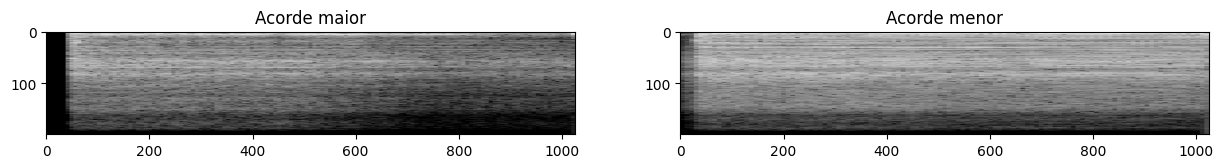

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].imshow(res_maj[0], cmap='gray')
axes[0].set_title("Acorde maior")

axes[1].imshow(res_min[0], cmap='gray')
axes[1].set_title("Acorde menor")

plt.show()

In [ ]:
# let's generate the labels, there 1 = Major chord and 0 = Minor chord

labels_maj = [1] * len(res_maj)
labels_min = [0] * len(res_min)

labels = np.array( labels_maj + labels_min )
data   = np.array( res_maj + res_min )

In [ ]:
# split into training and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.35, shuffle=True)

In [ ]:
# let's build the CNN

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, LeakyReLU

model = Sequential()

model.add(Conv2D(8, kernel_size=3, activation="relu", bias_initializer="zeros",
                      kernel_initializer='glorot_uniform', input_shape=(199, 1025, 1)))
model.add(MaxPooling2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.6))

model.add(Dense(10))
model.add(LeakyReLU(alpha=0.005))
model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 1023, 8)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 511, 8)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 98, 511, 8)       32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 98, 511, 8)        0         
                                                                 
 flatten (Flatten)           (None, 400624)            0         
                                                                 
 dropout_1 (Dropout)         (None, 400624)            0

In [ ]:
from keras.optimizers import Adam

opt = Adam(learning_rate=0.01)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=128)

Epoch 1/200
3/3 [==============================] - 8s 999ms/step - loss: 5.7043 - accuracy: 0.4755 - val_loss: 16.9552 - val_accuracy: 0.5682
Epoch 2/200
3/3 [==============================] - 1s 245ms/step - loss: 8.1339 - accuracy: 0.5429 - val_loss: 4.2585 - val_accuracy: 0.5625
Epoch 3/200
3/3 [==============================] - 1s 257ms/step - loss: 1.0422 - accuracy: 0.5215 - val_loss: 6.7697 - val_accuracy: 0.5227
Epoch 4/200
3/3 [==============================] - 1s 250ms/step - loss: 1.0271 - accuracy: 0.5920 - val_loss: 7.2710 - val_accuracy: 0.4943
Epoch 5/200
3/3 [==============================] - 1s 244ms/step - loss: 1.2447 - accuracy: 0.5337 - val_loss: 6.4933 - val_accuracy: 0.4943
Epoch 6/200
3/3 [==============================] - 1s 246ms/step - loss: 1.2580 - accuracy: 0.5368 - val_loss: 5.8483 - val_accuracy: 0.5170
Epoch 7/200
3/3 [==============================] - 1s 245ms/step - loss: 1.3632 - accuracy: 0.5368 - val_loss: 5.3992 - val_accuracy: 0.5114
Epoch 8/200


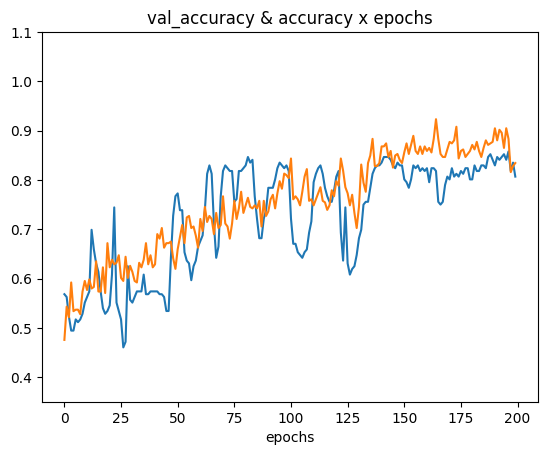

In [ ]:
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["accuracy"])
plt.title("val_accuracy & accuracy x epochs")
plt.xlabel("epochs")
plt.ylim(0.35, 1.1)

plt.show()